<a href="https://colab.research.google.com/github/compartia/creative/blob/stepped-activation/snowflakes/notebooks/snowcode_recogition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

trainset_name = 'trainset_1_fixed_colors'
zip_name=f'{trainset_name}.zip'
trainset_url = f'https://github.com/compartia/creative/releases/download/v1.0.0/{zip_name}'

!wget $trainset_url
!unzip -q $zip_name

In [0]:
BASE = 6 # here we're dealing 6-ary encoding
MAX_DIGITS=128
IMAGE_SIZE=[255, 255, 3]

# Read and prepare trainset

In [0]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

metadata = pd.read_csv(f'/content/{trainset_name}/metadata.csv')

In [0]:
def localize_fn(fn):
  return f'/content/{trainset_name}/' + fn.split('/')[-1]

## Prepare lables


### A) make float labels (Y) from integes `{0,1,2,...MAX} -> [0...1] == label/BASE` 

In [7]:
def convert_label(s:str)->[float]:
  return  [ float(c)/(BASE-1) for c in s ] 

print(convert_label(metadata['encoded6'][0]))

# Padding labels

labels = [convert_label(s) for s in metadata['encoded6']]
labels = pad_sequences(labels, maxlen=MAX_DIGITS, dtype='float32', padding='pre', truncating='pre', value=0.0)

[1.0, 0.8, 0.6, 0.4, 0.2, 0.6, 0.2, 1.0, 0.6, 0.4, 1.0, 0.2, 0.0, 0.0, 0.4, 1.0, 0.2, 0.4, 0.6, 0.8, 0.0, 1.0, 1.0, 0.8, 0.4, 1.0, 0.8, 0.6, 0.4, 0.8, 1.0, 0.6, 1.0, 0.8, 0.8, 0.6, 0.0, 1.0, 0.4, 0.8, 0.0, 0.4, 0.0, 0.8, 0.0, 0.4, 0.8, 0.6, 0.8, 0.2, 0.4, 0.0, 0.4, 0.2, 0.6, 1.0, 0.4, 0.6, 0.4, 0.6, 0.8, 0.6, 0.6, 0.8, 0.0, 1.0, 0.8, 0.6, 0.2, 0.4, 0.2, 0.6, 0.2, 1.0, 0.6, 1.0]


## Trainset Generators, augmentation, etc..

In [8]:
import os

import numpy as np  
import pandas as pd  

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, SeparableConv2D, BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda, MaxPooling2D)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.models import Model

import keras
print(f'keras version: {keras.__version__}')

from pathlib import Path


keras version: 2.3.1


In [0]:
metadata['image'] = [localize_fn(fn) for fn in metadata['filename'] ]

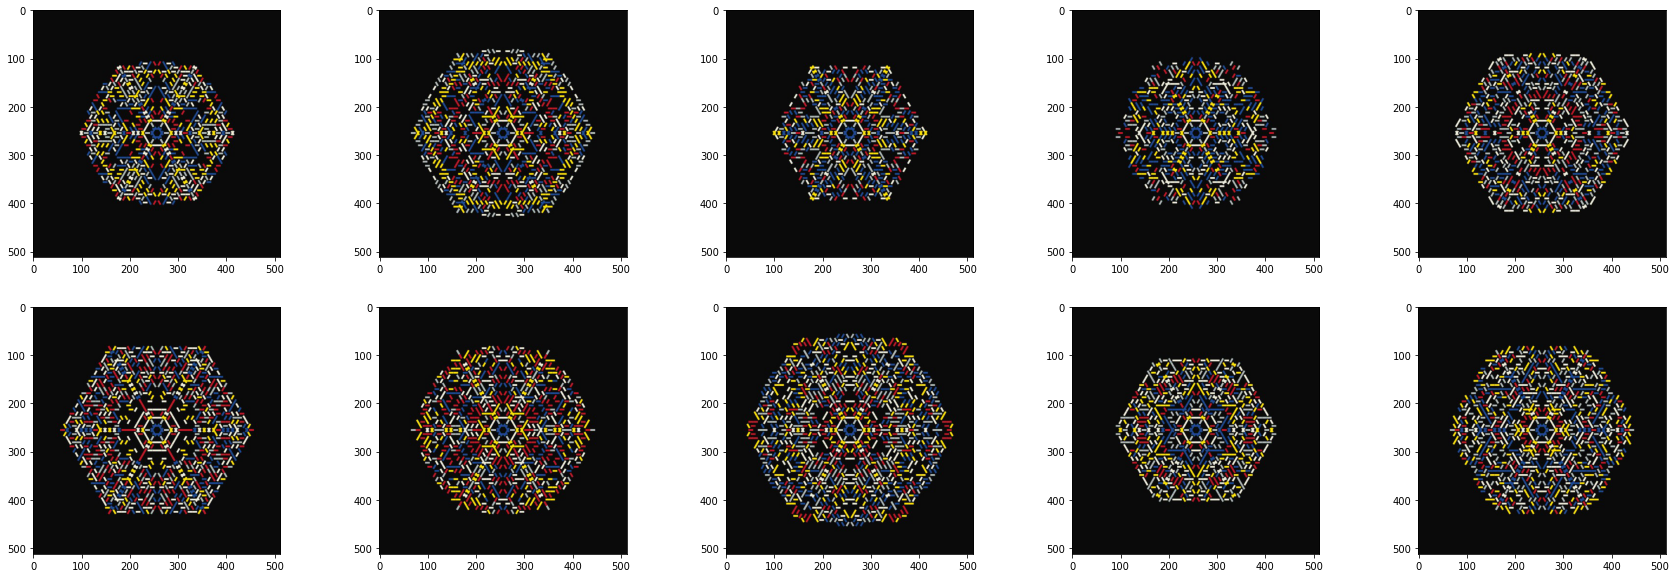

In [10]:
from PIL import Image
from skimage.io import imread
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(  metadata.loc[i, 'image'])
    ax[i//5, i%5].imshow(img) 
plt.show()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

images_cache={}
def get_image(pth):
  # print(pth)

  if pth not in images_cache:
    image = load_img(pth, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    image = img_to_array(image)
    images_cache[pth] = image
  
  return images_cache[pth]
  

img = get_image(metadata.image[1])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


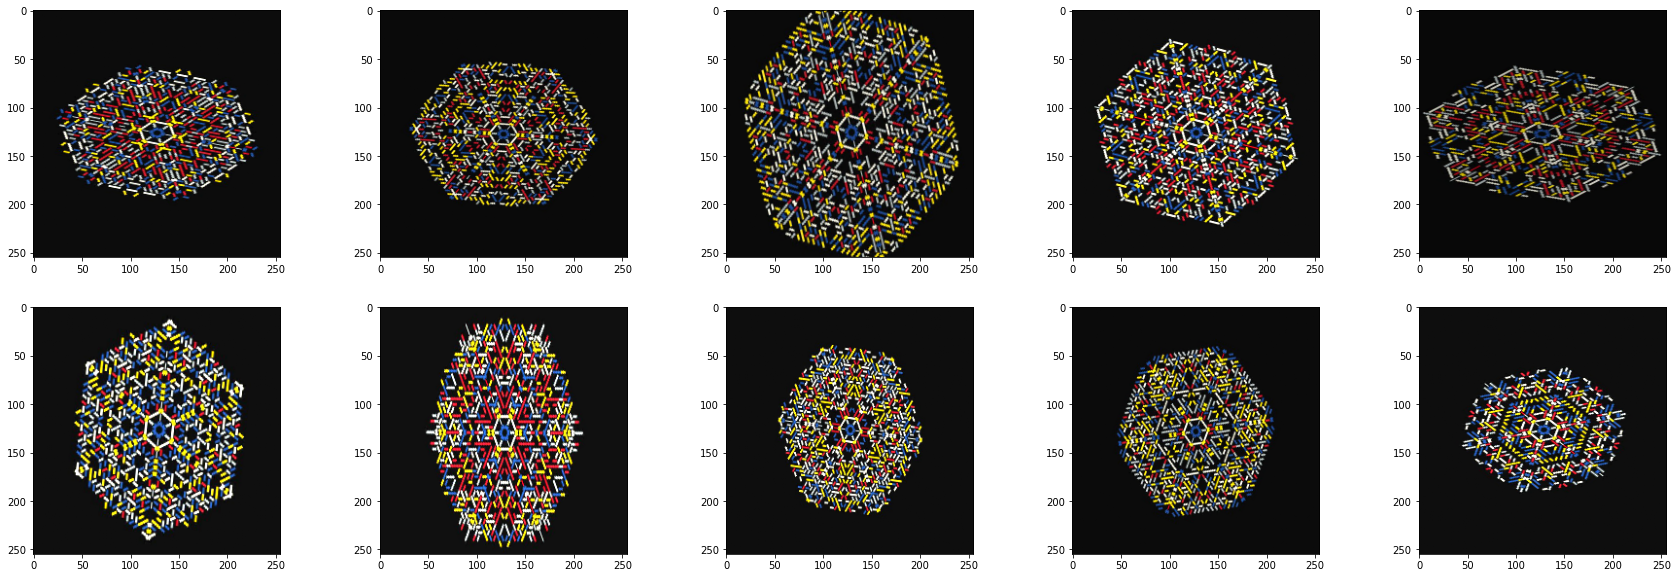

In [12]:



_dataset = list(zip(metadata.image.values, labels ))

test_dataset=_dataset[0:100]
train_dataset=_dataset[100:]

datagen = ImageDataGenerator(
    # rescale= 1./255.,    
    rotation_range=120, 
    zoom_range=0.3, 
    zca_whitening=True,
    shear_range=0.2, 
    brightness_range=[0.7,1.7]
    )

 
 

def get_generator( batch_size, _dataset):
  while True:
    # Select files (paths/indices) for the batch
    idx = np.random.randint(len(_dataset), size=batch_size)

    batch_input = []
    batch_output = []

    # Read in each input, perform preprocessing and get labels
    for i in idx:
      pair = _dataset[i]
      img = get_image(pair[0] )
      img =  datagen.random_transform(img)/255.
      label =  pair[1]      

      batch_input.append(img)
      batch_output.append(label)
 
    batch_x = np.array(batch_input)
    batch_y = np.array(batch_output)

    yield (batch_x, batch_y)


 
train_gen = get_generator(10, train_dataset );
test_gen = get_generator(10, test_dataset );
 
for k in range(1):
  # Plot the data 
  f, ax = plt.subplots(2,5, figsize=(30,10))

  images, labels = next(test_gen)
 
  for i in range(10):
    img = images[i]  
    ax[i//5, i%5].imshow(img ) 
  plt.show()

# The model

In [0]:
!pip install -U efficientnet

### Custom loss loss function
We do not care about the difference between actual and predicted values if the difference is grater than 1/6 (where 6 is the base) 

In other words, we clip error, if delta is > 1/6 

penalty (p) = 1 if abs delta > some epsilon;
a == true
b == predicted

\begin{equation*}
\epsilon = \frac {1}{base} = 1/6
\end{equation*}

\begin{equation*}
error = min(|a-b|, \epsilon)
\end{equation*}


 

 

In [0]:
 

NUM_CLASSES = BASE
def stepped_categorical(y_true, y_pred):     
    eps = 0.5 / NUM_CLASSES
    # print(eps)
    delta = K.abs(y_pred - y_true) #abs error
    delta = K.clip(delta, 0, eps) * 2 * NUM_CLASSES 
    
    return K.mean(delta*delta, axis=-1) #K.mean(delta*delta)

### Custom stepped activation function for dense label matrices
Thanks to Boris Kirillov  
will be used for Multi-label classification  


\begin{equation*}
Y=X-\frac{    \sin\left(2 \pi n \cdot X \right)}{2\pi n}
\end{equation*}

where n = BASE


In [0]:
# Define custom loss
import keras.backend as K
 
import math

_2PI_N:float=math.pi*2*BASE 
def stepped_activation(X):   
  Y = X - ( K.sin( X *_2PI_N )/_2PI_N )
  return Y



#### Test activation function

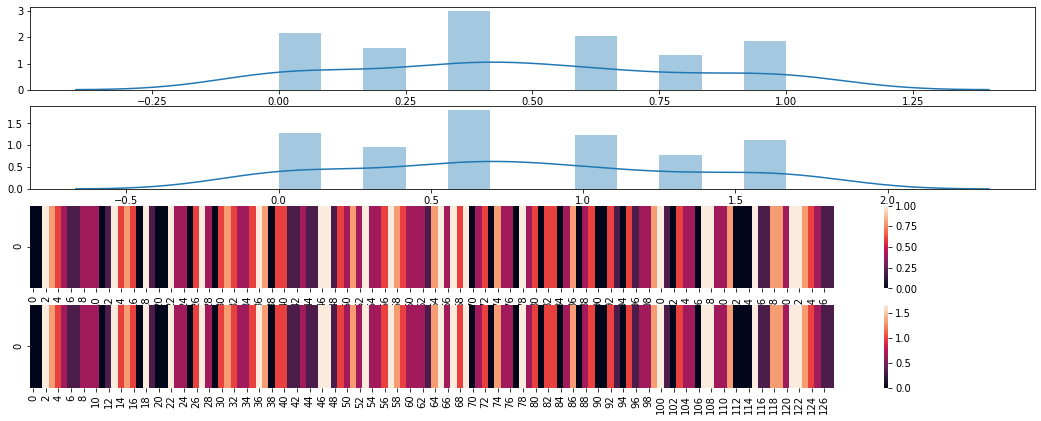

the distribution remains similar


In [16]:
_labels = train_dataset[0][1]
_l=_labels.reshape(-1, _labels.shape[-1])
_labels_act = stepped_activation(stepped_activation(_l * 1.66)) # multiply labels by a random C

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(18, 7))
 
sns.distplot(_l, bins=BASE*2, ax=ax1 )  
sns.distplot(_labels_act, bins=BASE*2 ,   ax=ax2 )  
sns.heatmap(_l, cmap="rocket",  ax=ax3 )
sns.heatmap(_labels_act, cmap="rocket",  ax=ax4 )
 
plt.show()
print("the distribution remains similar")

### Building graph on top of Efficientnet

In [17]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Reshape, Softmax, ReLU
from keras import Model

import efficientnet.keras as efn 

#////////////////////
FREEZE_LAYERS = False 
#////////////////////

base_model = efn.EfficientNetB4(weights='noisy-student', include_top=False)

x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)  

x = ReLU()(x)
x = Dense(MAX_DIGITS, activation = stepped_activation)(x)

model = Model(inputs=base_model.input, outputs=x)


if FREEZE_LAYERS:
  # fix the feature extraction part of the model
  for layer in base_model.layers:
      layer.trainable = False

  for layer in base_model.layers[-30:]:
      layer.trainable = True

 


71680000/71678424 [==============================] - 5s 0us/step


In [0]:
model.compile(optimizer='Nadam', loss='msle', metrics=['mse', 'msle'])
model.summary()

### fit

In [0]:
from google.colab import drive
drive.mount('/content/drive')

weights_checkpoint_path='/content/drive/My Drive/Projects/Snowflakes/stepped.weights.checkpoint'
model.load_weights(weights_checkpoint_path)
# model = load_model(checkpoint_path, custom_objects={'stepped_activation': stepped_activation})

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
 

es = EarlyStopping(patience=5)
chkpt_weights = ModelCheckpoint(filepath=weights_checkpoint_path, save_weights_only=True, verbose=1 )

if False:
  history = model.fit_generator(generator=train_gen,
                      steps_per_epoch=1500, 
                      validation_data=test_gen,
                      validation_steps=3,
                      epochs=100,                           
                      callbacks = [es, chkpt_weights],              
                    verbose=1)

# Analyse (predict) single augmented image


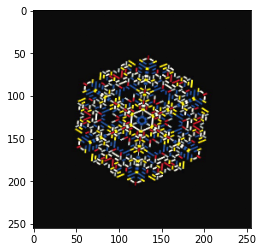

In [21]:
SAMPLE_INDEX=12
 

pt = _dataset[SAMPLE_INDEX]
img = get_image(pt[0])
img =  datagen.random_transform(img)/255.
plt.imshow(img) 

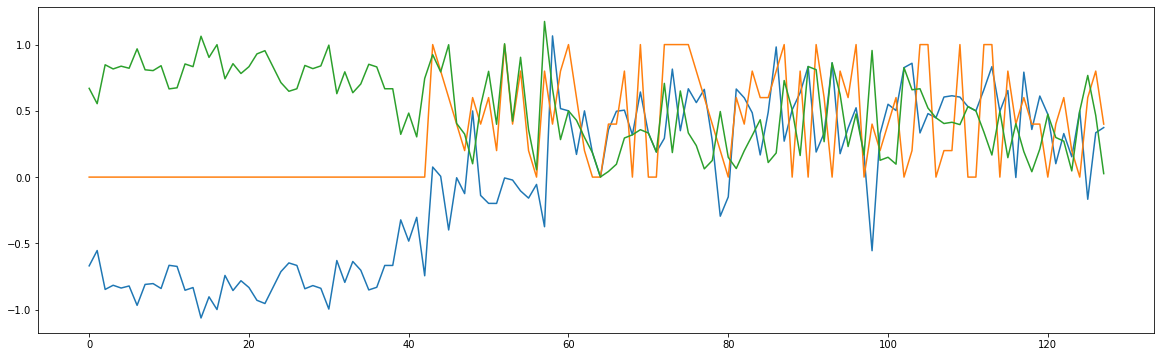

In [22]:
p=model.predict( np.array([img]) )[0]

plt.figure(figsize=(20,6))
plt.plot(p)
plt.plot(pt[1])

plt.plot( abs(pt[1]-p))

# decoding base6 encoded data

In [23]:
def restore_data(base6_encoded_string):
  a = int(base6_encoded_string, 6)
  b = a.to_bytes(128, byteorder='big')
  return b.decode("utf-8").replace('\x00','')



#-----------------TEST
if False:
  img = get_image(metadata.image[1])
  img =  datagen.random_transform(img)/255.
  p = model.predict( np.array([img]) )
  p[0]*5
  pc = [ int(round(v)) for v in p[0]*5 ]
  print(''.join(pc))
  print(metadata['encoded6'][1])


restore_data('431314044000115030505552302251520533005520512545202255454151215111544352332225525313414045113521001312220225')

'm|йFolamerando|йJameson|+36808329'

# TF lite

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()